In [23]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import HTML

In [24]:
#pd.set_option('display.max_rows', 500)

In [25]:
file = '../data/qspr-dataset-02.sdf'

frame = PandasTools.LoadSDF(file,smilesName='SMILES',molColName='Molecule',includeFingerprints=True)
#frame

RDKit WARNING: [15:11:56] Warning: molecule is tagged as 3D, but all Z coords are zero


In [26]:
suppl = Chem.SDMolSupplier(file)
mol_list = []
for mol in suppl:
    mol_list.append(mol)

RDKit WARNING: [15:11:57] Warning: molecule is tagged as 3D, but all Z coords are zero


In [27]:
#img = Draw.MolsToGridImage(mol_list, molsPerRow=4, maxMols=400)
#img

In [28]:
print(frame.dtypes)
frame = frame.astype({"pLC50": float})

pLC50       object
ID          object
SMILES      object
Molecule    object
dtype: object


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text major ticklabel objects>)

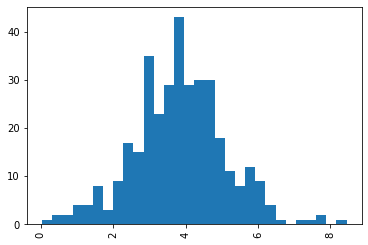

In [29]:
ax = plt.hist(frame["pLC50"].to_list(), bins = 30)
plt.xticks(rotation=90)

In [30]:
frame.describe()

,pLC50
count,352.000000
mean,3.842466
std,1.289585
min,0.037000
25%,3.020750
50%,3.832500
75%,4.657750
max,8.447000


In [31]:
def clean(x):
    #clean up molecule
    x = Chem.AddHs(x)
    AllChem.EmbedMolecule(x, randomSeed=0xf00d)
    return x

In [32]:
from rdkit.Geometry import Point3D
frame["Molecule_processed"] = frame["Molecule"].apply(lambda x: clean(x))


Row0
     RDKit          3D

 10 10  0  0  0  0  0  0  0  0999 V2000
   -1.1645    0.0160    0.0002 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3675    1.1392    0.0004 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.9782    0.7012    0.0002 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.9616   -0.6760   -0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3466   -1.0837   -0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  5  1  0
  1  2  2  0
  2  3  1  0
  3  4  2  0
  4  5  1  0
  1  6  1  0
  2  7  1  0
  3  8  1  0
  4  9  1  0
  5 10  1  0
M  END

Row1
     RDKit          3D

 33 32  0  0  0  0  0  0  0  0999 V2000
    0.8996    0.0039   -

In [37]:
HTML(frame.head().to_html())
rdkit.Chem.PandasTools.WriteSDF(frame, out="preprocessed_data.sdf", molColName="Molecule_processed")